In [2]:
import random

import gymnasium as gym
import numpy as np

import tensorflow as tf

from keras import Model
from keras.layers import Dense

In [3]:
class DQN(Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        self.replay_memory = []

        self.dense1 = Dense(128, activation="relu", input_dim=state_size)
        self.dense2 = Dense(128, activation="relu")
        self.dense3 = Dense(64, activation="relu")
        self.dense4 = Dense(32, activation="relu")
        self.dense5 = Dense(action_size, activation="softmax")

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)

        return x
    
    def remember(self, state, action, reward, next_state):
        self.replay_memory.append((state, action, reward, next_state))

In [4]:
def update_model(model: DQN):
    # 리플레이 버퍼 크기가 작으면 업데이트하지 않음
    if len(model.replay_memory) < 1000:
        return
    
    # 너무 많으면 리플레이 버퍼 pop
    if len(model.replay_memory) > 20000:
        del model.replay_memory[0]

    # # 메모리에서 랜덤 샘플링
    sample_size = 20
    samples = random.sample(model.replay_memory, sample_size)

    # 분할
    states, actions, rewards, next_states = zip(*samples)

    # numpy 배열로 변환
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    
    # 모델 예측과 타겟 값 계산
    targets = model.call(states).numpy()  # type: ignore
    next_q_values = model.call(next_states).numpy() # type: ignore

    targets[np.arange(len(samples)), actions] = rewards + 0.95 * np.max(next_q_values, axis=1)

    # 모델 업데이트
    with tf.GradientTape() as tape:
        q_values = model.call(states)
        loss = tf.keras.losses.mean_squared_error(targets, q_values)

    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [5]:
import os    
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def draw_qvalue(model, episode):
    thetas = np.arange(-np.pi, np.pi, 0.1)
    velocities = np.arange(-4, 4, 0.1)

    states = np.array([[np.cos(theta), np.sin(theta), velocity] for theta in thetas for velocity in velocities])
    z = model.call(states).numpy()
    z_np = np.array(z).reshape((len(thetas), len(velocities), 9))

    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle("Episode: {}".format(episode))
    for i in range(9):
        ax[i//5][i%5].title.set_text("Action: {}".format(i))
        ax[i//5][i%5].imshow(z_np[:,:,i], cmap='hot', interpolation='nearest', clim=(0, 1))
        ax[i//5][i%5].set_xticks(np.arange(0, 81, 10))
        ax[i//5][i%5].set_yticks(np.arange(0, 64, 10))
        ax[i//5][i%5].set_xticklabels(np.arange(-4, 5, 1))
        ax[i//5][i%5].set_yticklabels(np.round(np.arange(-np.pi, np.pi+0.1, 2*np.pi/6),1))
        ax[i//5][i%5].set_xlabel("Velocity")
        ax[i//5][i%5].set_ylabel("Theta")
        ax[i//5][i%5].invert_yaxis()  # y축 변경
    ax[1][4].axis('off')  # 마지막 subplot은 빈 공간

    plt.tight_layout()
    plt.savefig("model_final_image/episode_{}.png".format(episode))

-2 -4.496597410261246
-2 -4.853311595486224
-2 -5.429623349612911
-2 -6.215890634099727
-2 -7.191874521849199
-2 -8.323671054031077
-2 -9.563363870991456
0 -10.852773968222248
0 -10.676306692055173
0 -9.492135398334447
0 -8.340020797868128
0 -7.267730889172482
0 -6.320360705935681
0 -5.535004290597879
0 -4.938314866429632
0 -4.547157423080857
0 -4.375135979525362
-2 -4.3502510101605285
-2 -4.424096593081849
-2 -4.596383503526002
-2 -4.86514994139737
-2 -5.226139727874207
2 -5.668227491368933
2 -6.430336874036259
2 -7.4038190193693225
2 -8.553537799111197
2 -9.829895467955234
0 -11.172525198854041
0 -10.404672133669218
0 -9.242490977023833
0 -8.09990051553091
0 -7.023629099677989
0 -6.057753312776249
0 -5.23808794793907
0 -4.589570520722021
0 -4.126974874159465
0 -3.857540822788887
-2 -3.7989660387143793
-2 -3.9744461117513197
-2 -4.386425725099633
-2 -5.035226127924839
-2 -5.91483252248079
-2 -7.007275434506071
-2 -8.277682413097258
-2 -9.672814618074375
0 -11.125364717866148
0 -11.013

KeyboardInterrupt: 

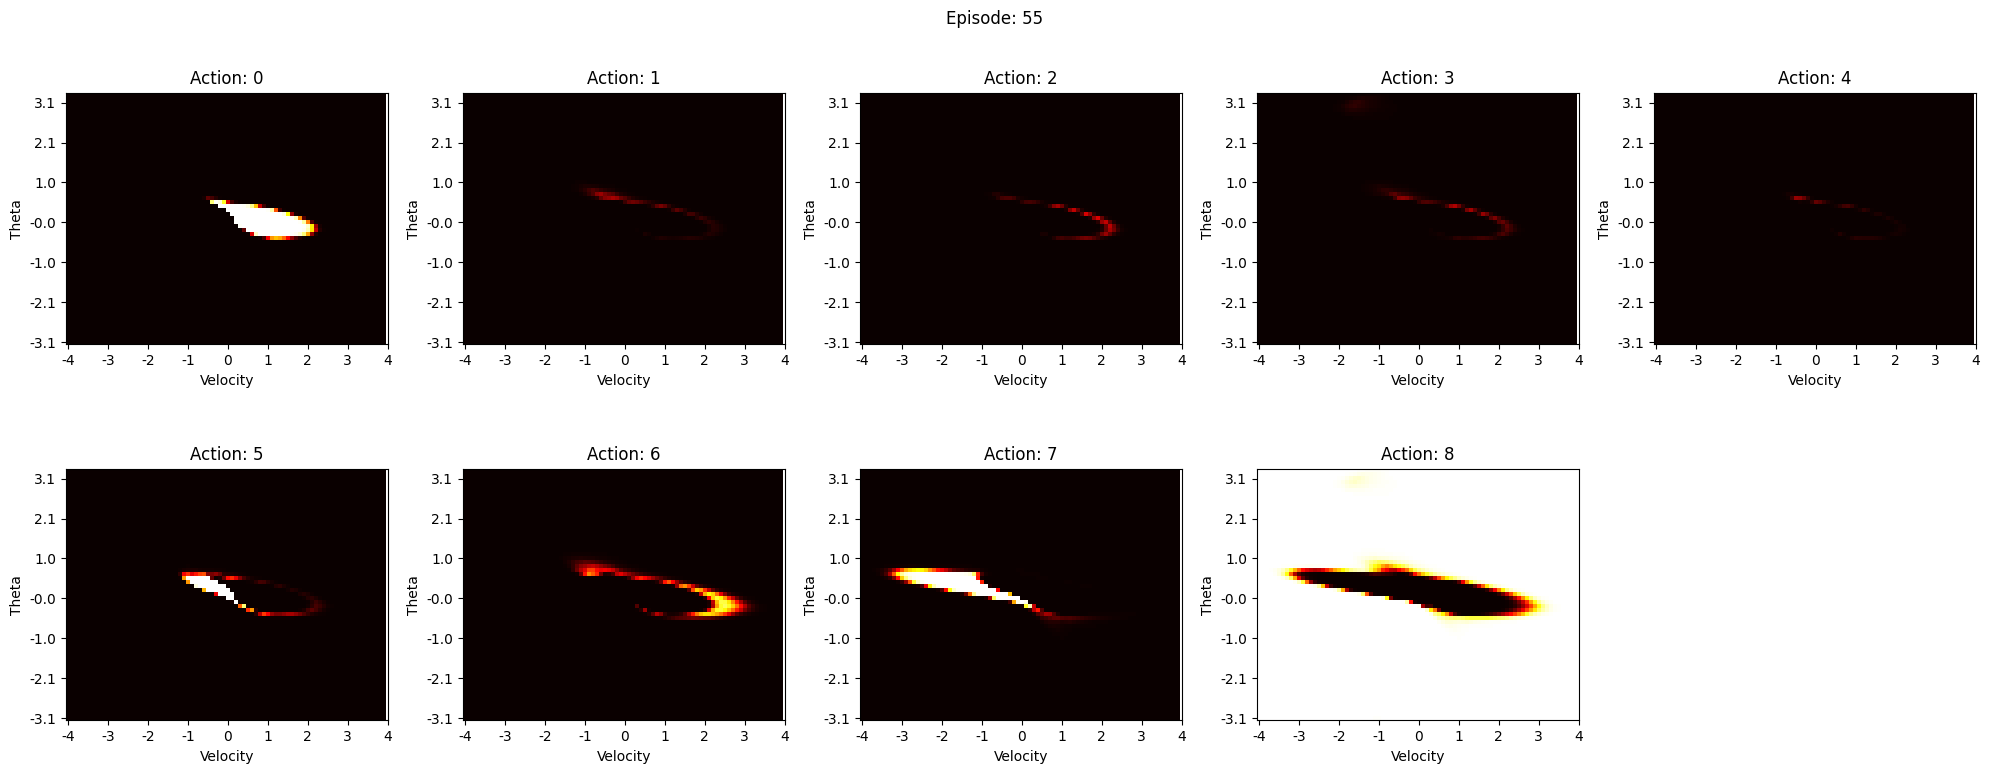

In [10]:
gravity = 10
# env = gym.make("Pendulum-v1", g=9.81, render_mode="human")
env = gym.make("Pendulum-v1", g=gravity, render_mode="human")
model = DQN(3, 9)
model.load_weights("model_final")

for episode in range(50):
    if episode % 10 == 0:
        env = gym.make("Pendulum-v1", g=gravity, render_mode="human")
    else:
        env = gym.make("Pendulum-v1", g=gravity)
    state, info = env.reset()
    terminated = False
    truncated = False
    step = 0

    rewards = []

    nice_state = False

    while not terminated and step < 500:

        # 모델로 행동 예측
        action = model.call(np.array([state])).numpy()[0]  # type: ignore
        action = np.random.choice(9, p=action)

        # 행동 실행
        next_state, reward, terminated, truncated, info = env.step((action/2-2,))

        if next_state[0] > 0.985 and abs(next_state[2]) < 0.2:
            nice_state = True
            reward += 50
        elif nice_state:
            nice_state = False
            reward -= 100

        if next_state[0] > 0.9:
            if next_state[0] < state[0]:
                if next_state[1] > 0:
                    if next_state[2] > state[2]:
                        reward -= 20
                    else:
                        reward += 10
                else:
                    if next_state[2] < state[2]:
                        reward -= 20
                    else:
                        reward += 10
            else:
                reward += 5
        
        elif next_state[0] < 0:
            if next_state[1] > 0 and next_state[2] > 0:
                if action > 4:
                    reward += 2
            elif next_state[1] < 0 and next_state[2] < 0:
                if action < 4:
                    reward += 2
        
        # 리플레이 버퍼에 기억
        model.remember(state, action, reward, next_state)
        
        # 모델 업데이트
        # if step % 50 == 0:
        update_model(model)

        state = next_state
        step += 1

        rewards.append(reward)

    if episode % 5 == 0:
        draw_qvalue(model, episode)
    
    print("Episode: {}, Steps: {}, Score: {:.2f}, Last Score: {:.2f}".format(episode, step, sum(rewards) / len(rewards), sum(rewards[-10:])/10))

env.close()

In [ ]:
model.save_weights('model_final', save_format='tf')